In [10]:
!pip install --upgrade pip
!pip install scikit-optimize
!pip install imblearn

Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/
Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/
Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/


In [11]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


In [12]:
# Function to calculate specificity and negative predictive value
def calculate_npv(y, y_pred):
    """
    Calculate the Negative Predictive Value (NPV) for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Calculate NPV
    npv = tn / (tn + fn)
    
    return npv 

# Function to evaluate the model
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    specificity =  specificity_score(y, y_pred)
    npv = calculate_npv(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_roc = roc_auc_score(y, y_prob)

    return accuracy, precision, recall, specificity, npv, f1, auc_roc

# Plot the AUC-ROC curve for each set
def plot_roc_curve(model, X, y, set_name):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ' + set_name)
    plt.legend(loc="lower right")
    plt.show()

    # Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show()

In [13]:
#Read data
filter_dir = os.path.join('/','home','ngsci','project','csv_files_and_genarators')
data_positive_label = pd.read_csv(os.path.join(filter_dir,'data_OHCA_preECGs_w24h.csv'))
data_negative_label = pd.read_csv(os.path.join(filter_dir,'data_ctrg_preECGs_wNdays.csv'))

print(data_positive_label.shape)
#print(data_positive_label.head(5))
#print(data_negative_label.head(5))
print(data_negative_label.shape)

#Concatanete both datasets
dataset_df = pd.concat([data_negative_label,data_positive_label], ignore_index=True)

#Remove IDs
dataset_df = dataset_df.drop(columns=['ecg_id', 'patient_id'])

(19, 26)
(247, 26)


In [14]:
#Apply SMOTE to minority class
ran_num=2
X = dataset_df.drop('label', axis=1)  # Features
y = dataset_df['label']  # Labels

# Count the current number of labels
count_label_1 = sum(y == 1)

# Initialize SMOTE with the desired ratio
resampling_factor=3
smote = SMOTE(sampling_strategy={1: count_label_1*resampling_factor}, random_state=ran_num)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with the resampled data
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

print("Original dataset shape:", dataset_df.shape)
print("Resampled dataset shape:", resampled_df.shape)
print("Original class distribution:\n", dataset_df['label'].value_counts())
print("Resampled class distribution:\n", resampled_df['label'].value_counts())

Original dataset shape: (266, 24)
Resampled dataset shape: (304, 24)
Original class distribution:
 label
0    247
1     19
Name: count, dtype: int64
Resampled class distribution:
 label
0    247
1     57
Name: count, dtype: int64


In [15]:
# Split the dataset into training, validation, and testing sets
train_df, val_df = train_test_split(resampled_df, test_size=0.3, random_state=ran_num)
#train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=ran_num)

# Define the features (X) and target (y)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

Train Set Metrics
Accuracy: 0.99
Precision: 1.00
Recall: 0.95
Specificity: 1.00
Negative Predictive Value: 0.99
F1-Score: 0.98
AUC-ROC: 1.00

Validation Set Metrics:
Accuracy: 0.92
Precision: 0.75
Recall: 0.80
Specificity: 0.95
Negative Predictive Value: 0.96
F1-Score: 0.77
AUC-ROC: 0.86


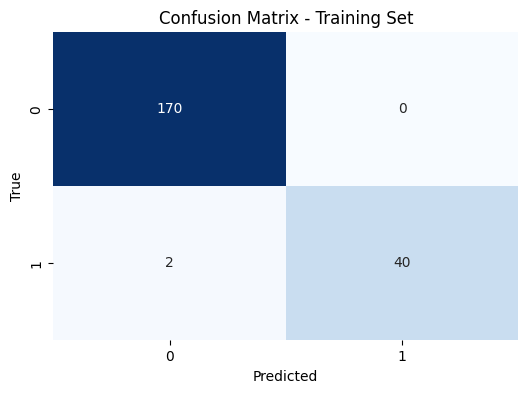

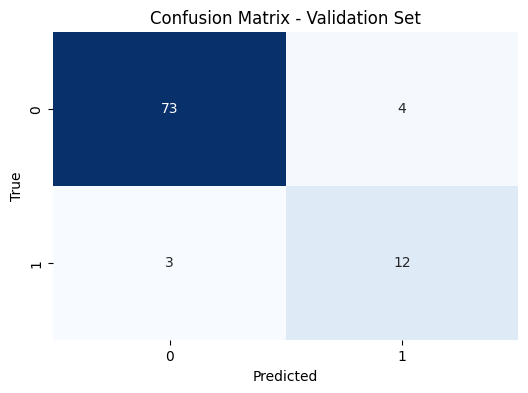

In [16]:
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=6, \
                              random_state=ran_num)

# Fit the model
clf.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
metrics_train = evaluate_model(clf, X_train, y_train)
metrics_val = evaluate_model(clf, X_val, y_val)

# Print the metrics
print("Train Set Metrics")
print("Accuracy: {:.2f}".format(metrics_train[0]))
print("Precision: {:.2f}".format(metrics_train[1]))
print("Recall: {:.2f}".format(metrics_train[2]))
print("Specificity: {:.2f}".format(metrics_train[3]))
print("Negative Predictive Value: {:.2f}".format(metrics_train[4]))
print("F1-Score: {:.2f}".format(metrics_train[5]))
print("AUC-ROC: {:.2f}".format(metrics_train[6]))

print("\nValidation Set Metrics:")
print("Accuracy: {:.2f}".format(metrics_val[0]))
print("Precision: {:.2f}".format(metrics_val[1]))
print("Recall: {:.2f}".format(metrics_val[2]))
print("Specificity: {:.2f}".format(metrics_val[3]))
print("Negative Predictive Value: {:.2f}".format(metrics_val[4]))
print("F1-Score: {:.2f}".format(metrics_val[5]))
print("AUC-ROC: {:.2f}".format(metrics_val[6]))

#Plot Confusion Matrix Training Set
y_train_pred = clf.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, 'Training Set')

#Plot Confusion Matrix Validation Set
y_val_pred = clf.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')

In [17]:
#Define everything for CV searching
inner_folds = 3
outer_folds = 5

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=ran_num)
cv_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=ran_num)

#Hyperparameteres to tune: 
# define search space
space = dict()
space['max_leaf_nodes'] = [5, 7, 10]
space['max_depth'] = [5, 7, 10]
space['max_features'] = [0.1, 0.5, 1]
#New space dimension
space['criterion'] = ['gini', 'entropy', 'log_loss']
space['class_weight'] = ['balanced',None]

# define the model
models = DecisionTreeClassifier(random_state=ran_num)

# define search
search = GridSearchCV(models, space, scoring='f1', n_jobs=1, cv=cv_inner, refit=True)


In [18]:
import time
start = time.perf_counter()

# Perform nested cross-validation
outer_F1 = []
outer_Pre = []
outer_Sens = []
outer_Spec = []
outer_Acc = []
outer_NPV = []

for train_idx, test_idx in cv_outer.split(X_resampled, y_resampled):
    X_cv_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_cv_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
    
    search.fit(X_cv_train, y_cv_train)

    # Train the model with the best hyperparameters on the outer training fold
    best_model = search.best_estimator_
    best_model.fit(X_cv_train, y_cv_train)

    # Evaluate the model on the outer validation fold
    y_pred = best_model.predict(X_test)
    outer_F1.append(f1_score(y_test, y_pred))
    outer_Pre.append(precision_score(y_test, y_pred))
    outer_Sens.append(recall_score(y_test, y_pred))
    outer_Acc.append(accuracy_score(y_test, y_pred))
    outer_Spec.append(specificity_score(y_test, y_pred))
    npv = calculate_npv(y_test, y_pred)
    outer_NPV.append(npv)
    
# Report the mean and standard deviation of the scores across the outer folds
#print(f"F1 nested cross-validation scores: {outer_scores}")
print(f"F1 mean score: {np.mean(outer_F1):.3f} +/- {np.std(outer_F1):.3f}")
print(f"Precision mean: {np.mean(outer_Pre):.3f} +/- {np.std(outer_Pre):.3f}")
print(f"Sensitivity mean: {np.mean(outer_Sens):.3f} +/- {np.std(outer_Sens):.3f}")
print(f"Specificity mean: {np.mean(outer_Spec):.3f} +/- {np.std(outer_Spec):.3f}")
print(f"NPV mean: {np.mean(outer_NPV):.3f} +/- {np.std(outer_NPV):.3f}")
print(f"Accuracy mean: {np.mean(outer_Acc):.3f} +/- {np.std(outer_Acc):.3f}")

end = time.perf_counter()
print(f"Time taken: {end - start:.6f} seconds")


F1 mean score: 0.657 +/- 0.052
Precision mean: 0.556 +/- 0.078
Sensitivity mean: 0.823 +/- 0.096
Specificity mean: 0.838 +/- 0.067
NPV mean: 0.956 +/- 0.024
Accuracy mean: 0.836 +/- 0.043
Time taken: 18.781035 seconds


In [20]:
# automatic nested cross-validation

# execute the nested cross-validation
scores = cross_val_score(search, X_resampled, y_resampled, scoring='f1', cv=cv_outer, n_jobs=-1)
# report performance
print('f1-score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

f1-score: 0.657 (0.052)


In [19]:
#Evaluate the best_model
best_model = search.fit(X_resampled, y_resampled).best_estimator_
metrics = ['accuracy', 'precision', 'recall', 'f1']

#caculate the metrics using cross validation
for metric in metrics:
    score = cross_val_score(best_model, X_resampled, y_resampled, scoring=metric, cv=cv_outer, n_jobs=-1)
    print(metric, ': mean %.3f and standard deviation (%.3f)' % (np.mean(score), np.std(score)))

#find the specificity
#from sklearn.metrics import recall_score
specificity = cross_val_score(best_model, X_resampled, y_resampled, scoring=make_scorer(recall_score, pos_label=0))
print('specificity: mean %.3f and standard deviation (%.3f)' % (np.mean(specificity), np.std(specificity)))

#find the npv
#from sklearn.metrics import make_scorer, precision_score
npvs = cross_val_score(best_model, X_resampled, y_resampled, scoring=make_scorer(precision_score, pos_label=0))
print('npv: mean %.3f and standard deviation (%.3f)' % (np.mean(npvs), np.std(npvs)))

accuracy : mean 0.829 and standard deviation (0.040)
precision : mean 0.528 and standard deviation (0.081)
recall : mean 0.803 and standard deviation (0.136)
f1 : mean 0.635 and standard deviation (0.097)
specificity: mean 0.805 and standard deviation (0.126)
npv: mean 0.945 and standard deviation (0.045)


In [11]:
best_model

DecisionTreeClassifier(max_depth=5, max_features=0.5, max_leaf_nodes=7,
                       random_state=42)

# END

In [8]:
features = list(X_train.columns)
fi = pd.DataFrame({'feature': features,
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
16,V1_RDUR,0.475160
12,V1_PDUR,0.159323
3,I_QAMP,0.141074
10,I_QRSDEF,0.075308
11,V1_PAMP,0.058740
1,I_PAMP,0.031441
20,V1_QRSDEF,0.030982
19,V1_QRSA,0.027972
14,V1_QDUR,0.000000
21,female,0.000000


In [12]:
#Find the best model using Bayesian optimization and Optuna

# The search_space can now be passed to BayesSearchCV
# the model is model
print(model)

# Define the search space
search_space = {
    'max_leaf_nodes': Integer(5, 10),
    'max_depth': Integer(2, 10),
    'max_features': Real(0.1, 1.0),
    'criterion' : Categorical(['gini', 'entropy', 'log_loss']),
    'class_weight' : Categorical(['balanced',None]),
}

# Create the Bayesian optimization object
optimizer = BayesSearchCV(
    model,
    search_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='f1',
    random_state=ran_num
)

# Fit the optimizer to the data
optimizer.fit(X_resampled, y_resampled)

# Print the best hyperparameters and score
print("Best hyperparameters:", optimizer.best_params_)
print("Best score:", optimizer.best_score_)

DecisionTreeClassifier(random_state=42)
Best hyperparameters: OrderedDict([('class_weight', None), ('criterion', 'gini'), ('max_depth', 6), ('max_features', 0.9213078542699094), ('max_leaf_nodes', 10)])
Best score: 0.7402703962703961


In [13]:
#Test the best model found 
best_model_BScv = optimizer.best_estimator_

#Test best score in training

cv_score = StratifiedKFold(n_splits=5, shuffle=True, random_state=ran_num)

#scores = cross_val_score(best_model_BScv, X_train, y_train, scoring='f1', cv=cv_train, n_jobs=-1)
scores = cross_val_score(best_model_BScv, X_resampled, y_resampled, scoring='f1', cv=cv_score, n_jobs=-1)

#print('f1-score-train: mean %.3f and standard deviation (%.3f)' % (np.mean(scores_train), np.std(scores_train)))
print('f1-score: mean %.3f and standard deviation (%.3f)' % (np.mean(scores), np.std(scores)))

f1-score: mean 0.681 and standard deviation (0.106)


# end 2


Validation Set Metrics:
Accuracy: 0.96
Precision: 1.00
Recall: 0.76
Specificity: 1.00
Negative Predictive Value: 0.95
F1-Score: 0.87


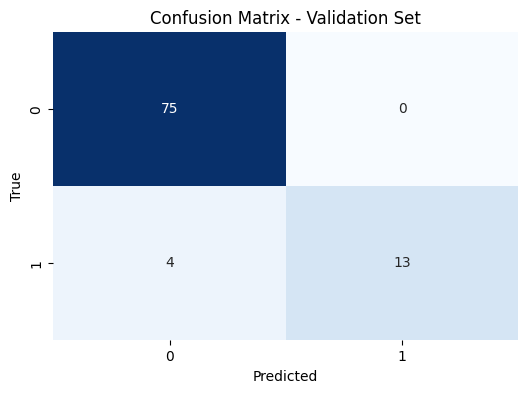

f1-score-val: mean 0.498 and standard deviation (0.228)


In [14]:
# Evaluate the model on validation, and test sets
metrics_val = evaluate_model(best_model_BScv, X_val, y_val)

print("\nValidation Set Metrics:")
print("Accuracy: {:.2f}".format(metrics_val[0]))
print("Precision: {:.2f}".format(metrics_val[1]))
print("Recall: {:.2f}".format(metrics_val[2]))
print("Specificity: {:.2f}".format(metrics_val[3]))
print("Negative Predictive Value: {:.2f}".format(metrics_val[4]))
print("F1-Score: {:.2f}".format(metrics_val[5]))

#Plot Confusion Matrix Validation Set
y_val_pred = best_model_BScv.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')

cv_val = StratifiedKFold(n_splits=3, shuffle=True, random_state=ran_num)
scores_val = cross_val_score(best_model_BScv, X_val, y_val, scoring='f1', cv=cv_val, n_jobs=-1)

print('f1-score-val: mean %.3f and standard deviation (%.3f)' % (np.mean(scores_val), np.std(scores_val)))